In [9]:
import os
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from typing import Any, Callable, Iterable, Optional


def merge_iterable(
    iterable: Iterable[Any],
    is_close: Callable[[Any, Any], bool],
    merge: Callable[[Any, Any], Any],
    apply: Optional[Callable[[Any], Any]] = None,
) -> Iterable[Any]:
    """Merges elements in sorted iterable"""
    merged = []
    for el in iterable:
        if apply is not None:
            el = apply(el)
        # if the list of merged elements is empty or if the current
        # element is not close with the previous, simply append it.
        if not merged or not is_close(merged[-1], el):
            merged.append(el)
        else:
            # otherwise, elements can be merged
            merged[-1] = merge(merged[-1], el)

    return merged


def records_close(a: tuple, b: tuple):
    return a[2] == b[2]

def records_merge(a: dict, b: dict):
    return (min(a[0], b[0]), max(a[1], b[1]), a[2])


def convert_vosk_result_to_speaker_intervals(path: str, segments_key: str = None) -> None:
    path_ = Path(os.path.abspath(path))
    name = path_.stem
    file_dir = path_.parent

    with open(str(path_), 'r') as f:
        data = json.load(f)

    if segments_key in data:
        segments = data[segments_key]
    else:
        segments = data
    
    intervals = [(x["start"], x["end"], x["speaker"]) for x in segments]

    # merged_intervals_by_speaker = merge_iterable(
    #     intervals, records_close, records_merge
    # )

    with open(file_dir / f'{name}_intervals.json', 'w') as f:
        json.dump(intervals, f)

In [3]:
convert_vosk_result_to_speaker_intervals("./experiments/test1_speaker_comp/test_1_vosk_result_with_speakers.json")
convert_vosk_result_to_speaker_intervals("./experiments/test2_speaker_comp/test_2_vosk_result_with_speakers.json")

In [4]:
def convert_speakers_json_to_rttm_like_txt(path: str) -> None:
    path_ = Path(os.path.abspath(path))
    name = path_.stem
    file_dir = path_.parent

    with open(str(path_), 'r') as f:
        data = json.load(f)

    lines = [
        f"{start} {end} {speaker}\n" for (start, end, speaker) in data
    ]
    
    # intervals = [(x["start"], x["end"], x["speaker"]) for x in segments]

    # merged_intervals_by_speaker = merge_iterable(
    #     intervals, records_close, records_merge
    # )

    with open(file_dir / f'{name}.txt', 'w') as f:
        f.writelines(lines)

In [80]:
convert_speakers_json_to_rttm_like_txt("./experiments/test1_speaker_comp/test_1_pyannote_spk_intervals.json")
convert_speakers_json_to_rttm_like_txt("./experiments/test1_speaker_comp/test_1_vosk_spk_intervals.json")
convert_speakers_json_to_rttm_like_txt("./experiments/test1_speaker_comp/truth.json")

convert_speakers_json_to_rttm_like_txt("./experiments/test2_speaker_comp/test_2_pyannote_results.json")
convert_speakers_json_to_rttm_like_txt("./experiments/test2_speaker_comp/test_2_vosk_result_with_speakers_intervals.json")
convert_speakers_json_to_rttm_like_txt("./experiments/test2_speaker_comp/truth.json")



In [53]:
speaker_mapping = {
    "speaker1": "speaker1",
    "speaker2": "speaker2",
    "speaker00": "speaker1",
    "speaker01": "speaker2",
}

speaker_colors = {
    "speaker1": "r",
    "speaker2": "g",
    "unknown": "b"
}

convert_speaker = lambda x: speaker_mapping.get(x.lower().replace("-", "").replace("_", ""), "unknown")


In [76]:
import matplotlib.patches as mpatches


#Plot function
def timelines(y, xstart, xstop, colors):
    """Plot timelines at y from xstart to xstop with given colors."""   
    plt.hlines(y, xstart, xstop, colors, lw=3)
    plt.vlines(xstart, y+0.03, y-0.03, colors, lw=1)
    plt.vlines(xstop, y+0.03, y-0.03, colors, lw=1)

def plot_intervals(
    files: list[str], 
    captions: list[str], 
    start_x: float, 
    end_x: float,
    figpath: str
) -> None:
    #Get unique captions and there indices and the inverse mapping
    captions, unique_idx, caption_inv = np.unique(captions, 1, 1)

    #Build y values from the number of unique captions.
    ys = (caption_inv + 1) / float(len(captions) + 1)

    for y, path in zip(ys, files):
        data = np.genfromtxt(
            path, 
            converters={2: convert_speaker},
            encoding="utf-8",
            names=['start', 'end', 'speaker'], dtype=None
        )
        speaker, start, end = data['speaker'], data['start'], data['end']

        timelines(np.asarray([y]*len(data)), start, end, np.asarray([speaker_colors[s] for s in speaker]))

    plt.yticks(ys[unique_idx], captions)
    plt.ylim(0, 1)
    plt.xlim(start_x, end_x)
    plt.legend(handles=[mpatches.Patch(color=speaker_colors[speaker], label=speaker) for speaker in speaker_colors])
    plt.xlabel('time (s)')
    plt.savefig(figpath, format='png')
    plt.show()

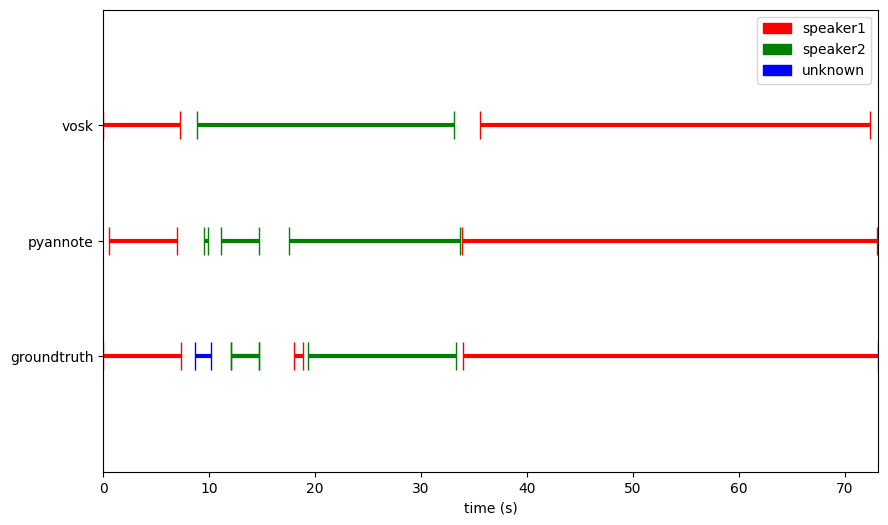

In [78]:
plt.figure(figsize=(10,6))


plot_intervals(
    files=[
        "./experiments/test1_speaker_comp/truth.txt",
        "./experiments/test1_speaker_comp/test_1_vosk_spk_intervals.txt",
        "./experiments/test1_speaker_comp/test_1_pyannote_spk_intervals.txt",
    ],
    captions=[
        "groundtruth",
        "vosk",
        "pyannote"
    ],
    start_x=0,
    end_x=73.15,
    figpath="./experiments/test1_speaker_comp/plot.png"
)

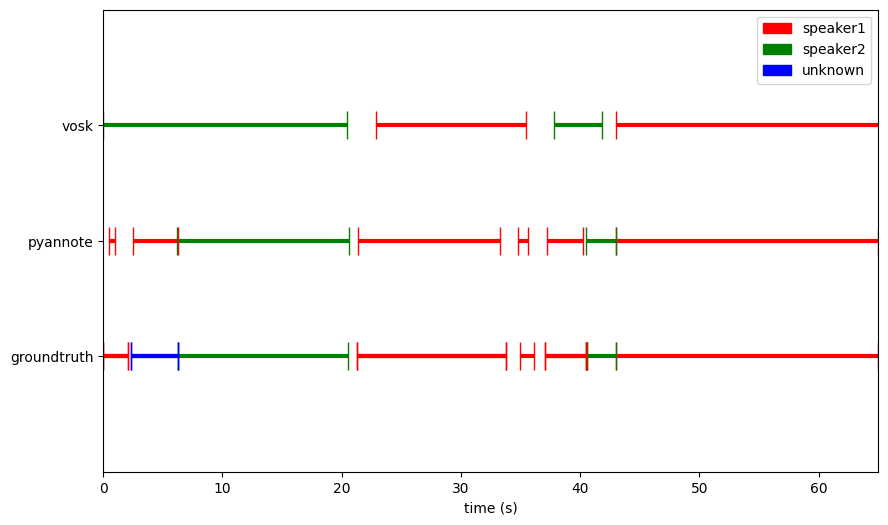

In [81]:
plt.figure(figsize=(10,6))


plot_intervals(
    files=[
        "./experiments/test2_speaker_comp/truth.txt",
        "./experiments/test2_speaker_comp/test_2_vosk_result_with_speakers_intervals.txt",
        "./experiments/test2_speaker_comp/test_2_pyannote_results.txt",
    ],
    captions=[
        "groundtruth",
        "vosk",
        "pyannote"
    ],
    start_x=0,
    end_x=65,
    figpath="./experiments/test2_speaker_comp/plot.png"
)

In [85]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core.annotation import Annotation, Segment

metric = DiarizationErrorRate()

In [84]:
def get_annotation_from_json(path) -> Annotation:
    path_ = Path(os.path.abspath(path))
    # name = path_.stem
    # file_dir = path_.parent

    with open(str(path_), 'r') as f:
        data = json.load(f)
    
    annotation = Annotation()
    for (start, end, speaker) in data:
        annotation[Segment(start, end)] = speaker

    return annotation


In [88]:
# experiment 1

truth_annotation = get_annotation_from_json("./experiments/test1_speaker_comp/truth.json")
vosk_annotation = get_annotation_from_json("./experiments/test1_speaker_comp/test_1_vosk_spk_intervals.json")
pyannote_annotation = get_annotation_from_json("./experiments/test1_speaker_comp/test_1_pyannote_spk_intervals.json")

vosk_der = metric(truth_annotation, vosk_annotation)
pyannote_der = metric(truth_annotation, pyannote_annotation)

print("Experiment 1 (test1)")
print(f'vosk diarization error rate = {100 * vosk_der:.1f}%')
print(f'pyannote diarization error rate = {100 * pyannote_der:.1f}%')

Experiment 1 (test1)
vosk diarization error rate = 16.2%
pyannote diarization error rate = 8.8%


/Users/sergeipetrov/Library/Caches/pypoetry/virtualenvs/test-xYtUzyB7-py3.10/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [89]:
# experiment 2

truth_annotation = get_annotation_from_json("./experiments/test2_speaker_comp/truth.json")
vosk_annotation = get_annotation_from_json("./experiments/test2_speaker_comp/test_2_vosk_result_with_speakers_intervals.json")
pyannote_annotation = get_annotation_from_json("./experiments/test2_speaker_comp/test_2_pyannote_results.json")

vosk_der = metric(truth_annotation, vosk_annotation)
pyannote_der = metric(truth_annotation, pyannote_annotation)

print("Experiment 2 (test2)")
print(f'vosk diarization error rate = {100 * vosk_der:.1f}%')
print(f'pyannote diarization error rate = {100 * pyannote_der:.1f}%')

Experiment 2 (test2)
vosk diarization error rate = 23.5%
pyannote diarization error rate = 12.1%
